In [1]:
import rdkit
import h5py
import numpy as np
import sys
sys.path.append('../..')
sys.path.append('../../../../transformer_pytorch')
from generative_playground.rdkit_utils.rdkit_utils import NormalizedScorer
from rdkit.Chem.rdmolfiles import MolFromSmiles
from rdkit.Chem.Descriptors import NumAromaticRings
from rdkit.Chem.Draw import MolsToGridImage

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


******************************
smiles -> nonH_bond
smiles -> initial_valence_1
smiles -> initial_valence_1 nonH_bond
smiles -> initial_valence_2 double_bond
smiles -> initial_valence_3 triple_bond
initial_valence_1 -> 'F'
initial_valence_1 -> 'Cl'
initial_valence_1 -> 'Br'
initial_valence_1 -> 'I'
initial_valence_1 -> '[' 'O' '-' ']'
initial_valence_1 -> '[' 'N' 'H' '3' '+' ']'
initial_valence_2 -> 'O'
initial_valence_2 -> 'S'
initial_valence_3 -> '[' 'C' '@' 'H' ']'
initial_valence_3 -> '[' 'C' '@' '@' 'H' ']'
initial_valence_3 -> 'N'
initial_valence_3 -> '[' 'N' 'H' '+' ']'
nonH_bond -> valence_1
nonH_bond -> valence_2
nonH_bond -> valence_2 nonH_bond
nonH_bond -> valence_3 double_bond
nonH_bond -> valence_4 triple_bond
double_bond -> '=' valence_2
double_bond -> '=' valence_3
double_bond -> '=' valence_3 nonH_bond
double_bond -> '=' valence_4 double_bond
triple_bond -> '#' valence_3
triple_bond -> '#' valence_4
triple_bond -> '#' valence_4 nonH_bond
valence_4 -> 'C'
valence_4 -> '['

improving: valence_4_num -> 'C' num inf 2 [0, 1]
improving: valence_2_num -> 'O' num inf 2 [0, 1]
improving: valence_3_num -> '[' 'C' '@' 'H' ']' num inf 2 [0, 0, 0, 0, 0, 1]
improving: valence_4_num -> 'C' num inf 2 [0, 1]
improving: num -> '1' inf 1 [0]
added  {'token': num, 'num': None, 'size': 11} from <frozendict {'token': valence_3_num, 'num': None, 'size': 10}> via valence_3_num -> '[' 'C' '@' 'H' ']' num
added  {'token': valence_4_num, 'num': None, 'size': 11} from <frozendict {'token': valence_3_num, 'num': None, 'size': 10}> via valence_3_num -> valence_4_num
improving: cycle_bond -> valence_2 cycle_bond inf 5 [1, 3]
improving: cycle_double_bond -> '=' valence_3 cycle_bond inf 5 [0, 1, 3]
improving: cycle_bond -> valence_2_num inf 3 [2]
improving: cycle_double_bond -> '=' valence_3_num inf 3 [0, 2]
improving: cycle_bond -> valence_2_num inf 3 [2]
improving: cycle_double_bond -> '=' valence_3_num inf 3 [0, 2]
improving: valence_2_num -> 'O' num inf 2 [0, 1]
improving: valence_

In [2]:
!dir "../train/pretrained/paper/"

 Volume in drive C is OS
 Volume Serial Number is 126A-86DF

 Directory of C:\Users\egork\Dropbox\GitHub\deep_games\generative_playground\src\generative_playground\train\pretrained\paper

11/09/2018  12:15 PM    <DIR>          .
11/09/2018  12:15 PM    <DIR>          ..
11/13/2018  11:10 AM           574,224 pg_smiles_anchor_weak.h5
10/02/2018  07:04 PM        64,964,759 pg_smiles_anchor_weak_sa20.h5
10/01/2018  06:22 AM        35,340,958 pg_smiles_anchor_wweak_sa20.h5
10/02/2018  07:02 PM        63,763,960 pg_smiles_anchor_wweak_sa20_cycle.h5
10/03/2018  06:20 AM        31,595,205 pg_smiles_no_anchor.h5
09/19/2018  02:06 PM         4,500,260 policy_gradient_baseline.h5
               6 File(s)    200,739,366 bytes
               2 Dir(s)  704,682,778,624 bytes free


In [3]:
from collections import OrderedDict
runs = OrderedDict(reversed([('Unconstrained',{'file':'pg_smiles_no_anchor.h5','range': 200}),
                   ('Weak Anchor, SA penalty',{'file':'pg_smiles_anchor_wweak_sa20.h5','range':1600}),
                   ('Weak Anchor, SA and aromatic cycle penalty',{'file':'pg_smiles_anchor_wweak_sa20_cycle.h5','range':3850}),
                   ('Strong Anchor, SA penalty',{'file':'pg_smiles_anchor_weak_sa20.h5','range':5800})]))
runs

OrderedDict([('Strong Anchor, SA penalty',
              {'file': 'pg_smiles_anchor_weak_sa20.h5', 'range': 5800}),
             ('Weak Anchor, SA and aromatic cycle penalty',
              {'file': 'pg_smiles_anchor_wweak_sa20_cycle.h5', 'range': 3850}),
             ('Weak Anchor, SA penalty',
              {'file': 'pg_smiles_anchor_wweak_sa20.h5', 'range': 1600}),
             ('Unconstrained',
              {'file': 'pg_smiles_no_anchor.h5', 'range': 200})])

In [4]:
def get_smiles_bunches(runs):
    bunches = []
    for key, value in runs.items():
        smiles_file = h5py.File('../train/pretrained/paper/' + runs[key]['file'],'r')
        smiles = np.array(smiles_file['smiles'])[runs[key]['range']*40:(runs[key]['range']+100)*40]
        bunches.append((key,smiles))
    return bunches

In [5]:
smiles_bunches = get_smiles_bunches(runs)
kusner1 ='CCCc1ccc(I)cc1C1CCC-c1'
kusner2 ='CC(C)CCCCCc1ccc(Cl)nc1'
kusner3 ='CCCc1ccc(Cl)cc1CCCCOC'
jin = 'c1c(Cl)ccc2c1cc(C(=O)C)c(C(=O)Nc3cc(NC(=O)Nc4cc(c5ccccc5(C))ccc4)ccc3)c2'

smiles_bunches = [('Kusner et al.', [kusner1, kusner2, kusner3]),
                  ('Jin et al.',[jin])] \
                    + smiles_bunches
smiles_bunches

[('Kusner et al.',
  ['CCCc1ccc(I)cc1C1CCC-c1',
   'CC(C)CCCCCc1ccc(Cl)nc1',
   'CCCc1ccc(Cl)cc1CCCCOC']),
 ('Jin et al.',
  ['c1c(Cl)ccc2c1cc(C(=O)C)c(C(=O)Nc3cc(NC(=O)Nc4cc(c5ccccc5(C))ccc4)ccc3)c2']),
 ('Strong Anchor, SA penalty',
  array(['CCc1csc([C@@H](C)NC(=O)Nc2ccc([N+](=O)[O-])cc2)n1',
         'NC(=O)c1c(Cl)cc(S(=O)(=O)c2ccc(F)c([N+](=O)[O-])c2)cc1',
         'COC(=O)CCC(=O)c1cccc(NC(=O)c2ccc(Cl)cc2)c1', ...,
         'CCC(C)(C)[C@@H](C)CNC(=O)[C@H]1CC(=O)N([C@@H](CC)c2ccc(Cl)cc2)C1',
         'COC(=O)C[C@H](O)c1c(F)cccc1N',
         'CNC(=O)c1ccc(C)c(C(=O)Nc2ccccc2C(F)(F)F)c1'], dtype=object)),
 ('Weak Anchor, SA and aromatic cycle penalty',
  array(['Oc1ccc(CNc2ncc(Oc3ccc(c4ccc(c5ccccc5)c(Cl)c4)cc3)c(Cc3cccs3)c2)cc1',
         'Cc1ccc(CS(=O)(=O)c2cc(N3CCC(CC(=O)N(Cc4ccc(Cl)cc4)C)C3)c(C)cc2)cc1',
         'Cc1cc([N+](=O)[O-])ccc1Nc1ccc(CSc2nc(C3CCCC3)cs2)cc1Br', ...,
         'CC(=O)NCc1ccc(CNc2ccc(Cl)cc2Nc2ccc(Cl)cc2Cl)cc1',
         'Cc1ccc(NC(=O)C(=O)N2CC[C@@H](Cc3cccc(C

In [6]:
import copy

def get_all_metrics(smiles):
    mols = [MolFromSmiles(s) for s in smiles]
    scores, norm_scores = NormalizedScorer().get_scores_from_mols(mols)
    arom_rings = np.array([NumAromaticRings(m) for m in mols])
    metrics = np.concatenate([scores.sum(axis=1)[:,None], 
                              norm_scores.sum(axis=1)[:,None], 
                              scores[:,1][:,None], 
                              norm_scores[:,1][:,None],
                              arom_rings[:,None]], 
                             axis=1)
    return (smiles,metrics)
    
def get_best(metrics_ext, name, num_best=1, thresh = 0):
    smiles, metrics = metrics_ext
    labels =['1st', '2nd', '3rd','4th', '5th']
    #print(num_best)
    metric_rows = []
    neg_sa = metrics[:,3] < thresh # we're only interested in positive SA
    pos_sa_scores = copy.deepcopy(metrics[:,1])
    pos_sa_scores[neg_sa] = -100
    for i in range(num_best):
        #print(i)
        best_ind = np.argmax(pos_sa_scores)
        if num_best > 1:
            this_name = name + ' ' + labels[i]
        else:
            this_name = name
        metric_rows.append((this_name, metrics[best_ind, :], smiles[best_ind]))
        pos_sa_scores[best_ind] = -100
    return metric_rows

In [8]:
def generate_metrics_list(smiles_bunches):
    metrics_list = []
    for name, s in smiles_bunches:
        file_name = name.replace(' ','').replace('.','').replace(',','') + '.pickle'
        print(file_name)
        try:
            raise ValueError("don't want to load now")
            with open(file_name,'rb') as f:
                metrics_ext = pickle.load(f)
        except:
            print('generating metrics...')
            metrics_ext = get_all_metrics(s)
            with open(file_name, 'wb') as f:
                import pickle
                pickle.dump(metrics_ext, f)

        metrics_list += get_best(metrics_ext, name, num_best = 3 if 'cycle' in name or 'Strong' in name else 1)
        print(name, metrics_list[-1])
    return metrics_list
metrics_list = generate_metrics_list(smiles_bunches)

Kusneretal.pickle
generating metrics...
Kusner et al. ('Kusner et al.', array([ 2.56397897,  2.93391534, -1.92992103,  1.34560546,  1.        ]), 'CC(C)CCCCCc1ccc(Cl)nc1')
Jinetal.pickle
generating metrics...
Jin et al. ('Jin et al.', array([ 6.24044483,  5.29827012, -2.32707517,  0.86986354,  5.        ]), 'c1c(Cl)ccc2c1cc(C(=O)C)c(C(=O)Nc3cc(NC(=O)Nc4cc(c5ccccc5(C))ccc4)ccc3)c2')
StrongAnchorSApenalty.pickle
generating metrics...
Strong Anchor, SA penalty ('Strong Anchor, SA penalty 3rd', array([ 6.6852052 ,  5.33430893, -2.8744148 ,  0.21421781,  5.        ]), 'Cc1cc(Nc2cncs2)c(Oc2ccc(Sc3nc(c4ccc(C(C)(C)C)cc4)sc3)cc2)cc1')
WeakAnchorSAandaromaticcyclepenalty.pickle
generating metrics...
Weak Anchor, SA and aromatic cycle penalty ('Weak Anchor, SA and aromatic cycle penalty 3rd', array([10.9979415 ,  8.44423491, -2.6684585 ,  0.46092819,  6.        ]), 'O=C(Nc1ccc(c2cc(Cl)cc(c3ccc(Cl)cc3)c2)cc1)c1cc(c2c(Cl)cc(Cl)cc2c2ccc(F)cc2Cl)cc(Cl)c1')
WeakAnchorSApenalty.pickle
generating metric

In [ ]:
# import pickle
# with open('metrics_list.pickle','rb') as f:
#     metrics_list = pickle.load(f)

In [10]:
best_smiles = [m[2] for m in metrics_list]
legends =[m[0] for m in metrics_list]
best_mols = [MolFromSmiles(s) for s in best_smiles]
# now let's output this nicely for LaTeX
for m_ in metrics_list:
    m = list(m_[1])
    m[-1] = int(m[-1])
    print(  m_[0] +' & {:.2f} & {:.2f} & {:.2f} & {:d} \\\\'.format(*m[1:]))

Kusner et al. & 2.93 & -1.93 & 1.35 & 1 \\
Jin et al. & 5.30 & -2.33 & 0.87 & 5 \\
Strong Anchor, SA penalty 1st & 5.68 & -1.96 & 1.31 & 5 \\
Strong Anchor, SA penalty 2nd & 5.60 & -2.62 & 0.52 & 4 \\
Strong Anchor, SA penalty 3rd & 5.33 & -2.87 & 0.21 & 5 \\
Weak Anchor, SA and aromatic cycle penalty 1st & 9.48 & -2.83 & 0.27 & 7 \\
Weak Anchor, SA and aromatic cycle penalty 2nd & 8.73 & -2.98 & 0.08 & 5 \\
Weak Anchor, SA and aromatic cycle penalty 3rd & 8.44 & -2.67 & 0.46 & 6 \\
Weak Anchor, SA penalty & 12.25 & -2.98 & 0.08 & 12 \\
Unconstrained & 46.45 & -1.00 & 2.46 & 13 \\


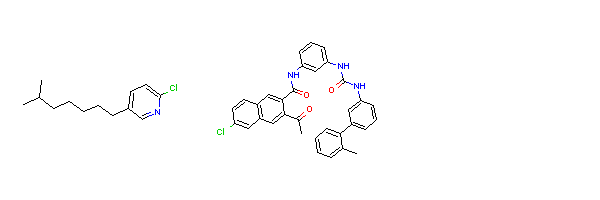

In [11]:
# groups = [[0,1],[2,3,4],[5,6,7],[8,9]]
# for g in groups[:1]:
#     MolsToGridImage([best_mols[gg] for gg in g], molsPerRow=3, subImgSize=(200, 200),legends= [legends[gg] for gg in g], useSVG=False)
MolsToGridImage(best_mols[:2], molsPerRow=3, subImgSize=(200, 200), useSVG=False)

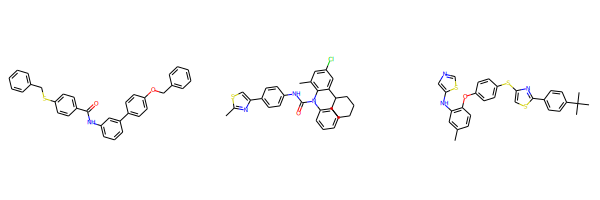

In [50]:
# groups = [[0,1],[2,3,4],[5,6,7],[8,9]]
# for g in groups[:1]:
#     MolsToGridImage([best_mols[gg] for gg in g], molsPerRow=3, subImgSize=(200, 200),legends= [legends[gg] for gg in g], useSVG=False)

def GridImageToFile(mols, fn):
    plot_str = MolsToGridImage(mols, molsPerRow=min(3,len(mols)), subImgSize=(200, 200), useSVG=True)
    plot_str = plot_str.replace('svg:', '')
    plot_str = plot_str.replace('stroke-width:2px','stroke-width:1px')
    #print(plot_str)
    plot_str = plot_str.replace('font-size:3px','font-size:6px')
    plot_str = plot_str.replace('font-size:4px','font-size:6px')
    from IPython.display import SVG, display
    display(SVG(data=plot_str))
    with open(fn, 'w') as myfile:
        myfile.write(plot_str)

GridImageToFile(best_mols[2:5],'strong.svg')


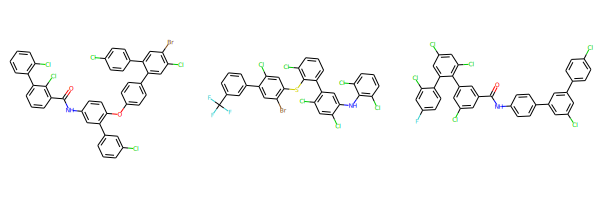

In [44]:
# groups = [[0,1],[2,3,4],[5,6,7],[8,9]]
# for g in groups[:1]:
#     MolsToGridImage([best_mols[gg] for gg in g], molsPerRow=3, subImgSize=(200, 200),legends= [legends[gg] for gg in g], useSVG=False)
#MolsToGridImage(best_mols[5:8], molsPerRow=3, subImgSize=(200, 200), useSVG=False)

GridImageToFile(best_mols[5:8],'weak.svg')

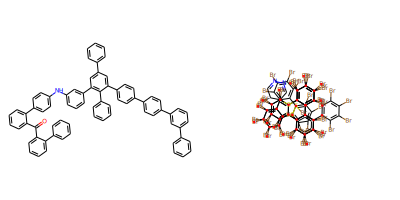

In [51]:
# groups = [[0,1],[2,3,4],[5,6,7],[8,9]]
# for g in groups[:1]:
#     MolsToGridImage([best_mols[gg] for gg in g], molsPerRow=3, subImgSize=(200, 200),legends= [legends[gg] for gg in g], useSVG=False)
MolsToGridImage(best_mols[8:], molsPerRow=2, subImgSize=(200, 200), useSVG=False)
GridImageToFile(best_mols[8:],'large.svg')